<a href="https://colab.research.google.com/github/roshan5619/Generative_AI/blob/main/20201CAI0002_GenAI_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anomaly Detection with AutoEncoders using **Tensorflow**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

In [17]:
!cat "/content/ECG5000_TRAIN.txt" "/content/ECG5000_TEST.txt" > ecg_final.txt
df = pd.read_csv("ecg_final.txt", sep='  ', header=None)
df.shape

<ipython-input-17-074b1302e8e0>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("ecg_final.txt", sep='  ', header=None)


(5000, 141)

In [18]:
df = df.add_prefix('c')
df['c0'].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: c0, dtype: int64

In [19]:
x_train, x_test, y_train, y_test =train_test_split(df.values, df.values[:,0:1], test_size=0.2, random_state=111)


In [20]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)
train_data_scaled = data_scaled.transform(x_train)
test_data_scaled = data_scaled.transform(x_test)

In [21]:
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

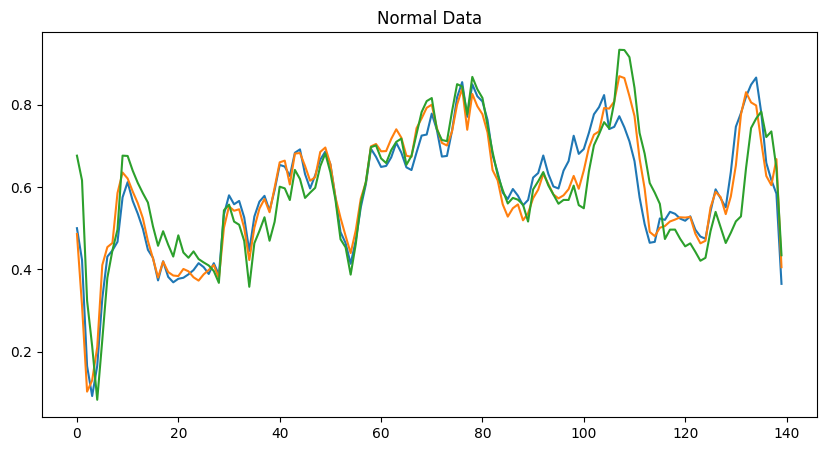

In [22]:
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])
plt.title("Normal Data")
plt.show()

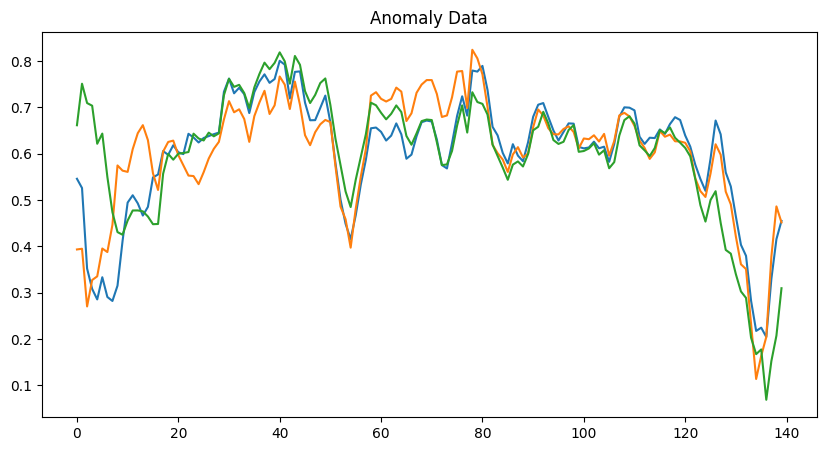

In [23]:
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])
plt.title("Anomaly Data")
plt.show()

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(140, activation="sigmoid"))

In [25]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(8, activation="relu")
              ])
    self.decoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(140, activation="sigmoid")
              ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [26]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
model.compile(optimizer='adam', loss="mae")
history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(train_data_scaled[:,1:], train_data_scaled[:, 1:]),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

Epoch 1/50
20/20 [==============================] - 2s 20ms/step - loss: 0.1346 - val_loss: 0.1251
Epoch 2/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0894 - val_loss: 0.0821
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0542 - val_loss: 0.0784
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0490 - val_loss: 0.0764
Epoch 5/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0481 - val_loss: 0.0763
Epoch 6/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0479 - val_loss: 0.0758
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0477 - val_loss: 0.0752
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0475 - val_loss: 0.0743
Epoch 9/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0471 - val_loss: 0.0735
Epoch 10/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0464 - val_loss: 0.0719
Epoch 11/50
20/2

In [27]:
encoder_out = model.encoder(normal_test_data).numpy() #8 unit representation of data
decoder_out = model.decoder(encoder_out).numpy()

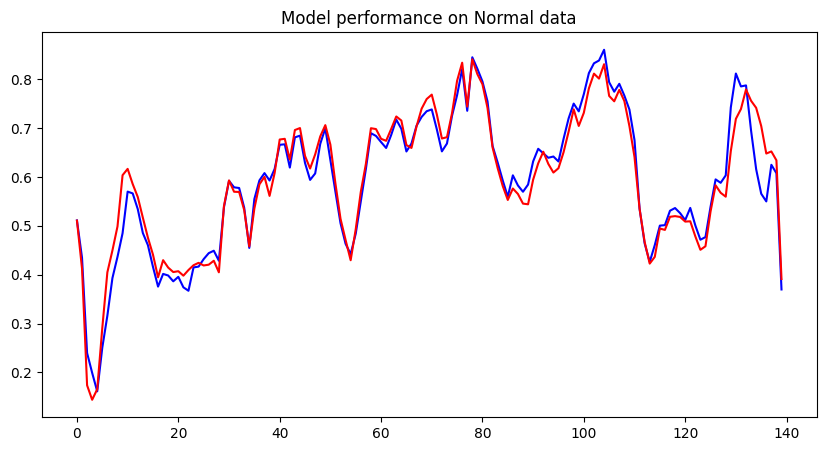

In [28]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')
plt.title("Model performance on Normal data")
plt.show()

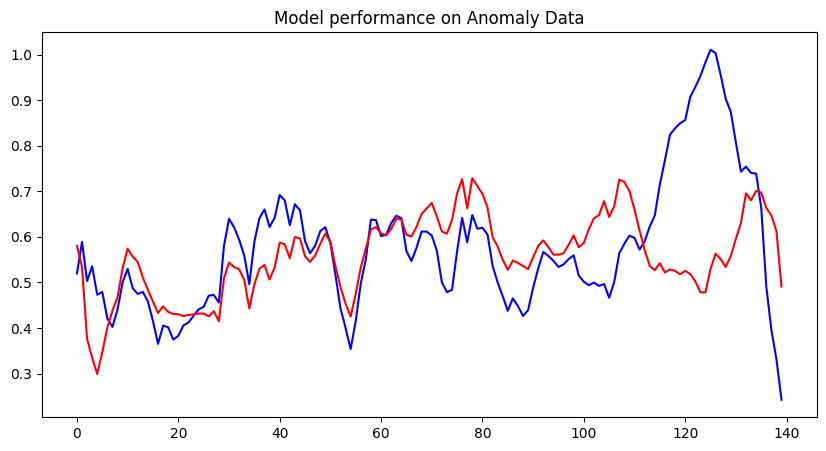

In [29]:
encoder_out_a = model.encoder(anomaly_test_data).numpy() #8 unit representation of data
decoder_out_a = model.decoder(encoder_out_a).numpy()
plt.plot(anomaly_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')
plt.title("Model performance on Anomaly Data")
plt.show()

18/18 [==============================] - 0s 2ms/step


(array([ 8., 19., 14., 44., 38., 42., 46., 37., 40., 30., 28., 25., 15.,
        17., 17., 14., 18., 10.,  8.,  9.,  7.,  8.,  9., 11.,  3.,  5.,
         4.,  4.,  4.,  8.,  3.,  2.,  0.,  0.,  2.,  0.,  1.,  2.,  2.,
         1.,  0.,  0.,  3.,  1.,  1.,  0.,  1.,  1.,  0.,  1.]),
 array([0.01245139, 0.01427321, 0.01609502, 0.01791683, 0.01973865,
        0.02156046, 0.02338228, 0.02520409, 0.0270259 , 0.02884772,
        0.03066953, 0.03249135, 0.03431316, 0.03613497, 0.03795679,
        0.0397786 , 0.04160042, 0.04342223, 0.04524404, 0.04706586,
        0.04888767, 0.05070948, 0.0525313 , 0.05435311, 0.05617493,
        0.05799674, 0.05981855, 0.06164037, 0.06346218, 0.065284  ,
        0.06710581, 0.06892762, 0.07074944, 0.07257125, 0.07439307,
        0.07621488, 0.07803669, 0.07985851, 0.08168032, 0.08350214,
        0.08532395, 0.08714576, 0.08896758, 0.09078939, 0.0926112 ,
        0.09443302, 0.09625483, 0.09807665, 0.09989846, 0.10172027,
        0.10354209]),
 <BarContainer

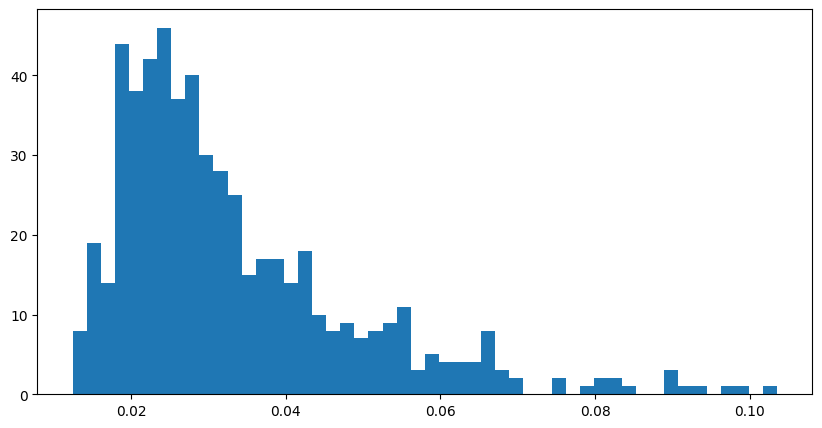

In [30]:
reconstruction = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_test_data)
plt.hist(train_loss, bins=50)

14/14 [==============================] - 0s 2ms/step


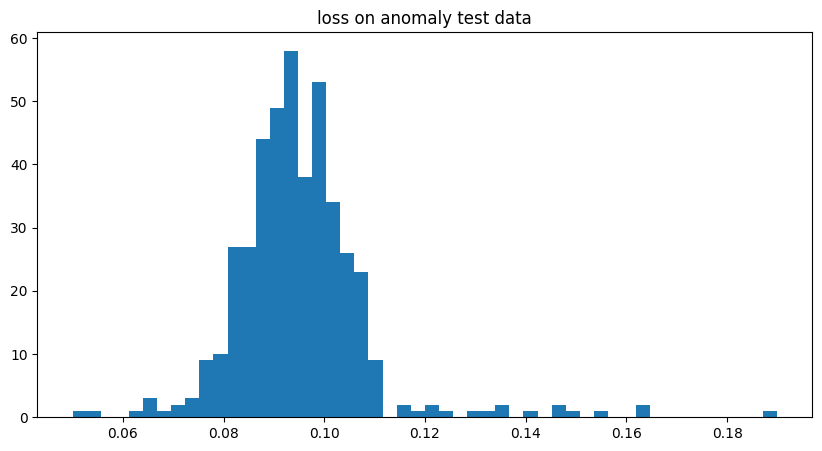

In [31]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
reconstruction_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomaly_test_data)
plt.hist(train_loss_a, bins=50)
plt.title("loss on anomaly test data")
plt.show()

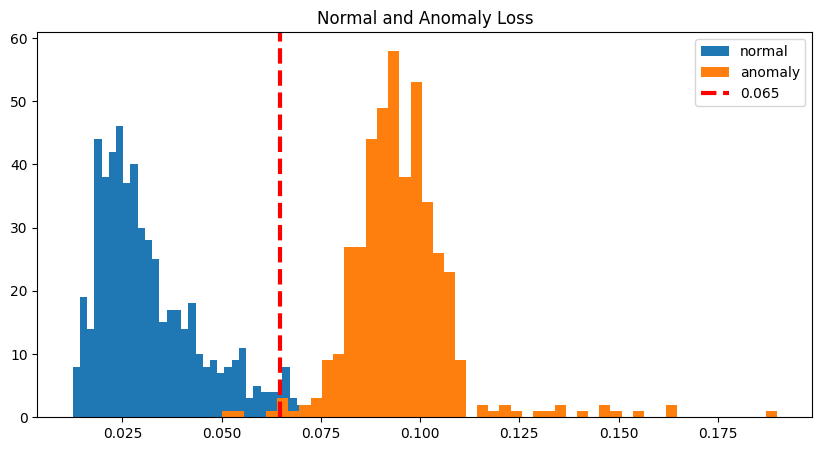

In [32]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

In [33]:
preds = tf.math.less(train_loss, threshold)
tf.math.count_nonzero(preds)

<tf.Tensor: shape=(), dtype=int64, numpy=533>

In [34]:
preds_a = tf.math.greater(train_loss_a, threshold)
tf.math.count_nonzero(preds_a)

<tf.Tensor: shape=(), dtype=int64, numpy=432>